# Benson Challenge

In [128]:
import sys
print("Python Version:", sys.version)

Python Version: 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


## Challenge 1

In [129]:
import pandas as pd

def csv_to_df(data_date):
    csv_file = "turnstile_{}.txt"
    dfs = []
    for date in data_date:
        data_file = csv_file.format(date)
        dfs.append(pd.read_csv(data_file))
    return pd.concat(dfs)

data_date = ["190608", "190615", "190622"]
df = csv_to_df(data_date)

### checking data frame

In [134]:
df.head()
#df.tail()
#df.info()

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/01/2019,00:00:00,REGULAR,7080105,2398899
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/01/2019,04:00:00,REGULAR,7080137,2398904
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/01/2019,08:00:00,REGULAR,7080161,2398937
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/01/2019,12:00:00,REGULAR,7080276,2399025
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/01/2019,16:00:00,REGULAR,7080520,2399084


### Clean column names

In [133]:
def rename_columns():
    column_names = ['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME', 'DESC', 'ENTRIES','EXITS']
    df.columns = [x.lower() for x in column_names]
rename_columns()

### checking unique elements

In [5]:
#df.groupby("time").time.count().sort_values(ascending = False)
#00: and 01: already comprise of 90% of the data! 10% of turnstiles don't submit the first data around midnight!
#df.groupby("date").date.count()
#df.entries.sort_values()

# Challenge 2

In [135]:
import dateutil.parser
from datetime import date

def produce_day_hour_column():
    par_funct = lambda row: dateutil.parser.parse(row["date"] + " " + row["time"])
    df["datetime"] = df.apply(par_funct, axis = 1)
    df["day"] = [x.day for x in df.datetime]
    df["hour"] = [x.hour for x in df.datetime]
produce_day_hour_column()

In [137]:
# df.head()

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,datetime,day,hour
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/01/2019,00:00:00,REGULAR,7080105,2398899,2019-06-01 00:00:00,1,0
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/01/2019,04:00:00,REGULAR,7080137,2398904,2019-06-01 04:00:00,1,4
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/01/2019,08:00:00,REGULAR,7080161,2398937,2019-06-01 08:00:00,1,8
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/01/2019,12:00:00,REGULAR,7080276,2399025,2019-06-01 12:00:00,1,12
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/01/2019,16:00:00,REGULAR,7080520,2399084,2019-06-01 16:00:00,1,16


# Challenge 3

In [138]:
turnstile_id = ["c/a", "unit", "scp", "station"]
turnstile_id_day = turnstile_id + ["day"]

### checking everything

In [193]:
#df.groupby(turnstile_id).entries.count()
#df.groupby(turnstile_id_day).entries.count().sort_values()
#entry_and_time_col = ["entries", "day", "hour"]
df.groupby(turnstile_id_day).hour.min().value_counts()
#dump all the data that starts after 4am (only 1 percent of total data)

0     54682
1     39880
2      4386
3      2471
4       417
5        67
12       27
7        19
13       17
8        12
9        10
16        8
20        7
6         7
11        6
17        6
15        5
10        3
19        3
14        2
18        2
21        1
22        1
Name: hour, dtype: int64

In [144]:
#mask_test = ((df["c/a"] == "PTH18") & (df["unit"] == "R549") & (df["scp"] == "01-01-03") & (df["station"] == "NEWARK BM BW"))
#df[mask_test & (df.day == 12)]

In [145]:
# are all the cumulative entry counts integers? If function returns nan, cleaning algorithm will be needed
def integer_check():
    for i, value in enumerate(df.entries):
        if type(value) != int:
            print(value)
        elif i == len(df.entries) - 1:
            print("all are int!")
integer_check()

all are int!


# Drop duplicate to keep the earilest data each day

In [149]:
def keep_earliest_hour():
    df1 = df.sort_values('hour', ascending=True).drop_duplicates(turnstile_id_day)
    return df1.sort_values(turnstile_id_day).reset_index(drop=True)
df_keep_earliest_hour = keep_earliest_hour()

In [152]:
#df_keep_earliest_hour is the daily cumulative count
#df_keep_earliest_hour.hour.value_counts()
#now drop the rows recorded after 4am
#df_keep_earliest_hour.tail()

### drop data after 4am

In [156]:
#some turnstiles submit the first data of each day at noon, we can't do the daily count based on them.
def keep_midnight():
    return df_keep_earliest_hour[df_keep_earliest_hour.hour < 4].reset_index(drop=True)
df_keep_midnight = keep_midnight()
#df_keep_midnight.hour.value_counts()
#df_keep_midnight.head()

### checking if turnstiles all have 21 days of data

In [160]:
# df_keep_midnight.groupby(turnstile_id).entries.count().value_counts()
# 5% of the data has missing day, if wednesday is missing, we might have 
#Wednesday_daily_count = Thursday_cumulative_count - Tuesday_cumulative_count, more cleaning needed!

21    4418
20     266
19      87
18      43
16      24
17      15
13       6
15       3
9        3
14       3
2        2
1        2
12       2
6        1
5        1
10       1
8        1
4        1
Name: entries, dtype: int64

# Filter rows with less than 21 days of data
### filter rows by results of groupby!

In [162]:
def filter_day_span():
    return df_keep_midnight.groupby(turnstile_id).filter(lambda x: x["entries"].count() > 20).reset_index(drop=True)
df_filter_day_span = filter_day_span()

In [166]:
# df_filter_day_span.head()
#checking the day span is correct
# df_filter_day_span.groupby(turnstile_id).entries.count().value_counts()

# Check the cleaning process again

In [175]:
#df_filter_day_span.info()
#df_filter_day_span.tail()
# df_filter_day_span.columns
# df_filter_day_span.sample(n = 5, random_state= 41)
# df_filter_day_span.hour.value_counts()
# df_filter_day_span.groupby(turnstile_id).day.count().value_counts()
# df_filter_day_span.entries.max()
#2 billions almost equals to 2 ** 31 , is there a upper limit at which cumulative count got resetted?

# Daily entries count

In [176]:
def order_by_day():
    return df_filter_day_span.sort_values(turnstile_id_day).reset_index(drop = True)
df_order_by_day = order_by_day()
#df_order_by_day.count()

c/a         92778
unit        92778
scp         92778
station     92778
linename    92778
division    92778
date        92778
time        92778
desc        92778
entries     92778
exits       92778
datetime    92778
day         92778
hour        92778
dtype: int64

In [177]:
#produce subframe to compute the daily entries, then concatenate to the original dataframe
def diff_daily_count():
    df_sub = df_filter_day_span[["entries"]]
    df_daily_count = df_sub.diff()
    df_daily_count.columns = ["daily_count"]
    return pd.concat([df_order_by_day, df_daily_count], axis=1).reset_index(drop=True)
df_diff_daily_count = diff_daily_count()
#df_diff_daily_count.head()

### add previous day 

In [179]:
def add_prev_day():
    df_day = df_diff_daily_count[["date"]]
    df_day_shifted = df_day.shift()
    df_day_shifted.columns = ["prev_date"]
    return pd.concat([df_diff_daily_count, df_day_shifted], axis=1)
df_add_prev_day = add_prev_day()
df_add_prev_day.head()

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,datetime,day,hour,daily_count,prev_date
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/01/2019,00:00:00,REGULAR,7080105,2398899,2019-06-01,1,0,NaN,NaN
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/02/2019,00:00:00,REGULAR,7081001,2399154,2019-06-02,2,0,896.0,06/01/2019
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/03/2019,00:00:00,REGULAR,7081661,2399345,2019-06-03,3,0,660.0,06/02/2019
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/04/2019,00:00:00,REGULAR,7083157,2399747,2019-06-04,4,0,1496.0,06/03/2019
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2019,00:00:00,REGULAR,7084813,2400180,2019-06-05,5,0,1656.0,06/04/2019


### subtraction produces nan, drop the first day!

In [180]:
def drop_first_day():
    return df_add_prev_day[(df_add_prev_day.day != 1)].reset_index(drop=True)
turnstile_df = drop_first_day()

# drop positive and negative outliers in daily_entry column

In [184]:
def functioning_turnstile_count_by_day():
    for n in range(2, 22):
        print(turnstile_df[(turnstile_df.day == n)].daily_count.count())
#functioning_turnstile_count_by_day()
#all the remaining turnstiles records data during the time span

In [181]:
#turnstile_df[(turnstile_df.daily_count > 20000)]
#1.8 billion of people went through a turnstile machine in one day?! That's 4 times the US population!

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,datetime,day,hour,daily_count,prev_date
6786,B020,R263,00-03-01,AVENUE H,BQ,BMT,06/08/2019,00:00:00,REGULAR,1376289,262231,2019-06-08 00:00:00,8,0,1.367583e+06,06/07/2019
28152,N111,R284,00-06-02,CLINTON-WASH AV,C,IND,06/14/2019,00:00:00,REGULAR,852357,277,2019-06-14 00:00:00,14,0,8.516890e+05,06/13/2019
32353,N207,R104,00-00-00,167 ST,BD,IND,06/15/2019,00:00:00,REGULAR,1828703710,1828766679,2019-06-15 00:00:00,15,0,1.819016e+09,06/14/2019
72425,R293,R133,00-06-01,MOSHOLU PKWY,4,IRT,06/07/2019,01:00:00,REGULAR,452993428,67129009,2019-06-07 01:00:00,7,1,4.511630e+08,06/06/2019
73538,R311,R053,00-00-01,3 AV-149 ST,25,IRT,06/20/2019,00:00:00,REGULAR,704681890,1056970651,2019-06-20 00:00:00,20,0,7.019235e+08,06/19/2019


In [185]:
#by looking at the busiest stations we set the daily count upper bound to 20000
max_daily_cap = 20000
def drop_positive_outlier():
    return turnstile_df.groupby(turnstile_id).filter(lambda x: x['daily_count'].max()< max_daily_cap).reset_index(drop=True)
df_drop_p_outlier = drop_positive_outlier()

In [188]:
# df_drop_p_outlier[(df_drop_p_outlier.daily_count >max_daily_cap)]
# df_drop_p_outlier[(df_drop_p_outlier.daily_count < 0 )]

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,datetime,day,hour,daily_count,prev_date
1440,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,BMT,06/02/2019,00:00:00,REGULAR,1238344895,1813324633,2019-06-02 00:00:00,2,0,-2672.0,06/01/2019
1441,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,BMT,06/03/2019,00:00:00,REGULAR,1238342655,1813325636,2019-06-03 00:00:00,3,0,-2240.0,06/02/2019
1442,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,BMT,06/04/2019,00:00:00,REGULAR,1238338892,1813327450,2019-06-04 00:00:00,4,0,-3763.0,06/03/2019
1443,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,BMT,06/05/2019,00:00:00,REGULAR,1238335043,1813329292,2019-06-05 00:00:00,5,0,-3849.0,06/04/2019
1444,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,BMT,06/06/2019,00:00:00,REGULAR,1238331186,1813331252,2019-06-06 00:00:00,6,0,-3857.0,06/05/2019
1445,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,BMT,06/07/2019,00:00:00,REGULAR,1238327028,1813333120,2019-06-07 00:00:00,7,0,-4158.0,06/06/2019
1446,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,BMT,06/08/2019,00:00:00,REGULAR,1238323046,1813335127,2019-06-08 00:00:00,8,0,-3982.0,06/07/2019
1447,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,BMT,06/09/2019,00:00:00,REGULAR,1238320664,1813336539,2019-06-09 00:00:00,9,0,-2382.0,06/08/2019
1448,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,BMT,06/10/2019,00:00:00,REGULAR,1238318519,1813337530,2019-06-10 00:00:00,10,0,-2145.0,06/09/2019
1449,A025,R023,01-03-01,34 ST-HERALD SQ,BDFMNQRW,BMT,06/11/2019,00:00:00,REGULAR,1238314926,1813339246,2019-06-11 00:00:00,11,0,-3593.0,06/10/2019


In [191]:
#now drop the neqative data, and the remaining data is sparkling clean!
def cleaned_data():
    return df_drop_p_outlier.groupby(turnstile_id).filter(lambda x: x['daily_count'].min() > 0).reset_index(drop=True)
df_cleaned = cleaned_data()
#df_cleaned[(df_cleaned.daily_count < 0)]

# Challenge 4

In [27]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

mask = ((df_cleaned["c/a"] == "A002") & 
(df_cleaned["unit"] == "R051") & 
(df_cleaned["scp"] == "02-00-00") & 
(df_cleaned["station"] == "59 ST"))
# datetime is both name of module and name of constructor of datetime object
df_cleaned[mask]

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,datetime,day,hour,daily_count,prev_date
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/02/2019,00:00:00,REGULAR,7081001,2399154,2019-06-02,2,0,896.0,06/01/2019
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/03/2019,00:00:00,REGULAR,7081661,2399345,2019-06-03,3,0,660.0,06/02/2019
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/04/2019,00:00:00,REGULAR,7083157,2399747,2019-06-04,4,0,1496.0,06/03/2019
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/05/2019,00:00:00,REGULAR,7084813,2400180,2019-06-05,5,0,1656.0,06/04/2019
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/06/2019,00:00:00,REGULAR,7086363,2400727,2019-06-06,6,0,1550.0,06/05/2019
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/07/2019,00:00:00,REGULAR,7087917,2401244,2019-06-07,7,0,1554.0,06/06/2019
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/08/2019,00:00:00,REGULAR,7089463,2401758,2019-06-08,8,0,1546.0,06/07/2019
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/09/2019,00:00:00,REGULAR,7090281,2402005,2019-06-09,9,0,818.0,06/08/2019
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/10/2019,00:00:00,REGULAR,7091020,2402182,2019-06-10,10,0,739.0,06/09/2019
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/11/2019,00:00:00,REGULAR,7092450,2402667,2019-06-11,11,0,1430.0,06/10/2019


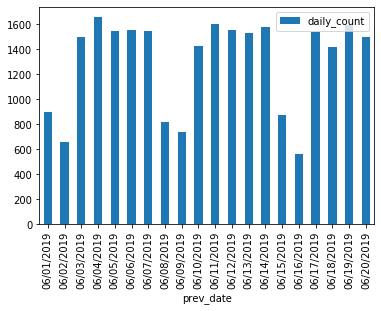

In [99]:
ax = df_cleaned[mask].plot.bar(x='prev_date', y='daily_count', rot=90)
#ax = df_cleaned[mask].plot.bar

In [29]:
#df_cleaned.info()

In [30]:
df_cleaned[((df_cleaned.day == 5) & (df_cleaned.daily_count > 5000))][["station", "daily_count"]]

,station,daily_count
583,57 ST-7 AV,6315.0
1023,34 ST-HERALD SQ,5610.0
1063,34 ST-HERALD SQ,5015.0
1903,14 ST-UNION SQ,5653.0
8863,8 AV,5286.0
10463,BEDFORD AV,5948.0
17203,59 ST COLUMBUS,5329.0
17223,59 ST COLUMBUS,5126.0
20183,W 4 ST-WASH SQ,5880.0
34423,34 ST-HERALD SQ,5700.0


# Analysis over a single week

In [ ]:
#we choose a condition to consider data in a single week.
one_week_condition = (df_cleaned.day >= 2) & (df_cleaned.day <= 8)

In [90]:
df_cleaned[one_week_condition & (df_cleaned.station == "GRD CNTRL-42 ST")]\
.groupby(["station", "day"]).daily_count.sum().sort_values()

station          day
GRD CNTRL-42 ST  3       39994.0
                 2       49742.0
                 8      107316.0
                 6      113025.0
                 4      113304.0
                 5      116678.0
                 7      117663.0
Name: daily_count, dtype: float64

In [91]:
df_cleaned[one_week_condition & (df_cleaned.station == "34 ST-PENN STA")]\
.groupby(["station", "day"]).daily_count.sum().sort_values()

station         day
34 ST-PENN STA  3       78109.0
                2       82910.0
                8      158999.0
                4      163683.0
                5      164457.0
                6      166802.0
                7      172376.0
Name: daily_count, dtype: float64

In [46]:
#different stations
df_cleaned.station.nunique()

337

## station daily entry

In [88]:
df_station_daily = df_cleaned[one_week_condition].groupby(["station", "day"], as_index=False)\
.agg({"daily_count" : "sum"}).reset_index(drop=True)
#df_station_daily.head()

,station,day,daily_count
0,1 AV,2,7053.0
1,1 AV,3,5157.0
2,1 AV,4,8118.0
3,1 AV,5,8079.0
4,1 AV,6,8479.0


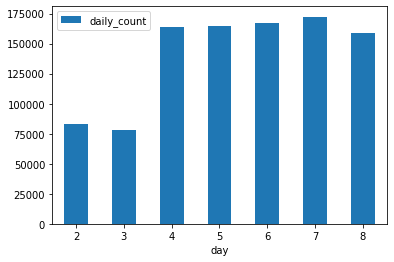

In [127]:
df_penn = df_station_daily[df_station_daily.station == "34 ST-PENN STA"] 
ax = df_penn.plot.bar(x='day', y='daily_count', rot=0)

## station weekly total

In [117]:
df_station_weekly =  df_station_daily.groupby(["station"], as_index = False)\
.agg({"daily_count": "sum" }).sort_values(["daily_count"], ascending=False).reset_index(drop=True)

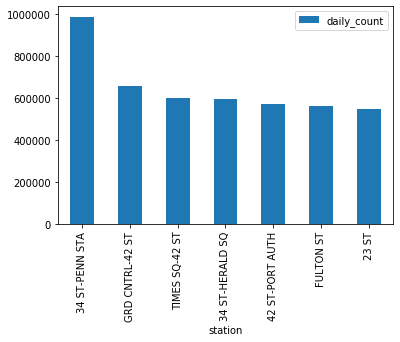

In [120]:
ax = df_station_weekly[df_station_weekly.daily_count > 550000].plot.bar(x='station', y='daily_count', rot=90)

## weekly_total MTA count by day of week

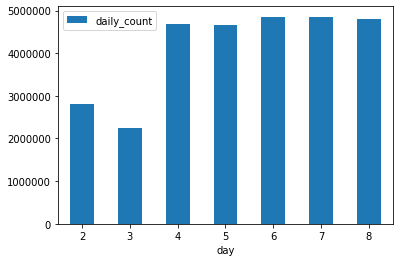

In [105]:
#to compare which day is the busiest day of week:
df_day_of_week_total = df_cleaned[one_week_condition].groupby(["day"], as_index=False).daily_count.sum()
ax = df_day_of_week_total.plot.bar(x='day', y='daily_count', rot=0)
#df_day_of_week_total